# Personalized cancer diagnosis

#### Problem statement :
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from collections import Counter, defaultdict
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# reading variant data
data = pd.read_csv('msk-redefining-cancer-treatment/training_variants.csv')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
# reading text data
# note the seprator in this file
data_text =pd.read_csv("msk-redefining-cancer-treatment/training_text.csv",sep="\|\|",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


#### Preprocessing Text

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ',total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 93.6731939 seconds


In [6]:
# merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


#### Test, Train & Cross Validation split

In [10]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# spliting the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2,random_state=1)

# spliting the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,random_state=1)


print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])


Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


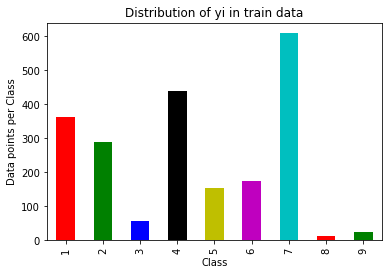

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
----------------------------------------------------------------------------------------------------


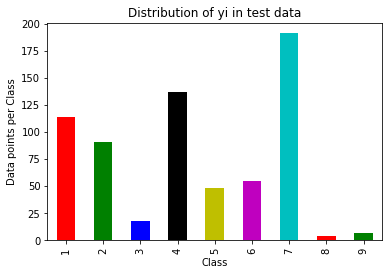

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
----------------------------------------------------------------------------------------------------


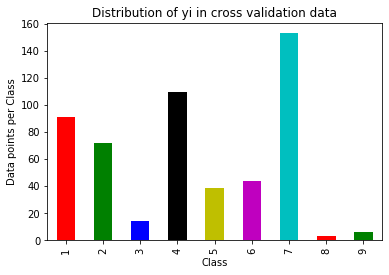

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [11]:
# ploting distribution of target veriable(class) in train, test and cross validation data

train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()


my_colors = list('rgbkymc')
plt.subplot()
train_class_distribution.plot(kind='bar',color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i],
          '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
print('-'*100)



test_class_distribution.plot(kind='bar',color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i],
          '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
print('-'*100)



cv_class_distribution.plot(kind='bar',color = my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i],
          '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


#### Creating a function to plot Confusion Matrix, Precision & Recall

In [12]:

def plot_confusion_matrix(test_y, predict_y):
    '''This function plots the confusion matrices given test_y_i, predicted_y_i. '''

    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    
    print("\t\t\t"+"-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(18,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # ploting B in heatmap format
    print("\t\t\t"+"-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(18,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # ploting A in heatmap format
    print("\t\t\t"+"-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(18,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Applying a random model

Log loss on Cross Validation Data using Random Model 2.525412283788545
Log loss on Test Data using Random Model 2.460546384547489
			-------------------- Confusion matrix --------------------


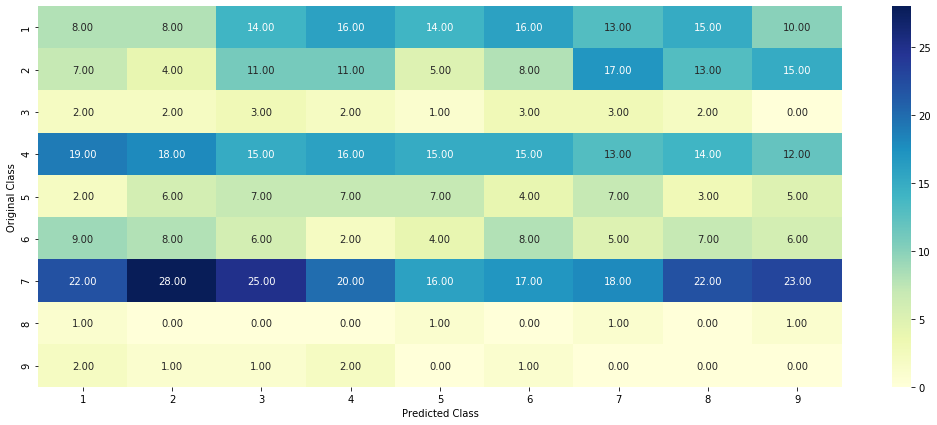

			-------------------- Precision matrix (Columm Sum=1) --------------------


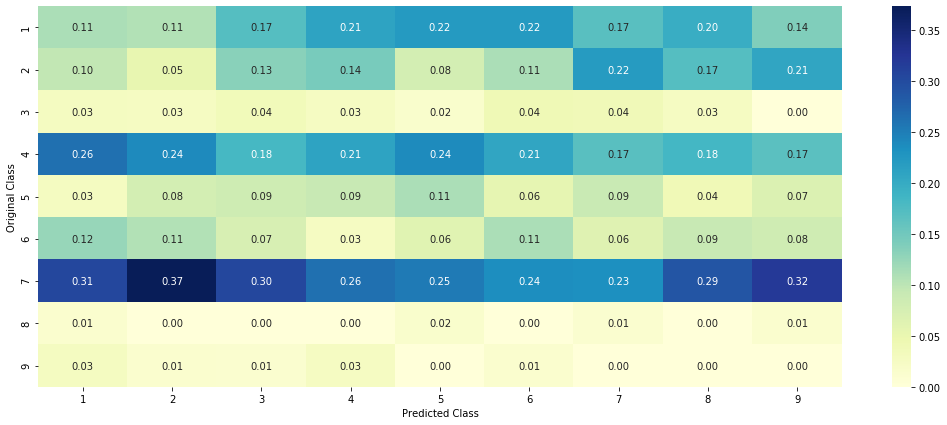

			-------------------- Recall matrix (Row sum=1) --------------------


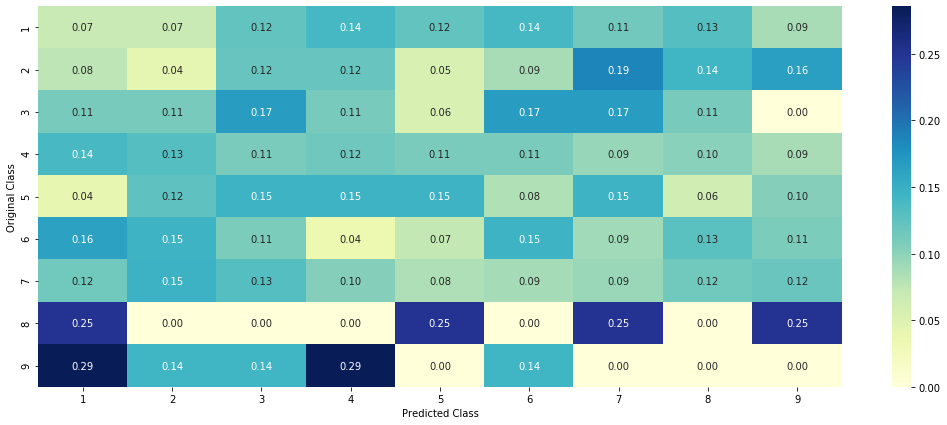

In [13]:

test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# creating a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    # need to generate 9 numbers and the sum of numbers should be 1
    cv_predicted_y[i] = (rand_probs/sum(np.ravel(rand_probs)))[0]
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y))


# Test-Set error.

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = (rand_probs/sum(np.ravel(rand_probs)))[0]
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

### Univariate Analysis on Gene Feature

In [14]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print("*"*40+"\nThe top 10 genes that occured most:")
print(unique_genes.head(10))

Number of Unique Genes : 235
****************************************
The top 10 genes that occured most:
BRCA1     168
TP53      111
PTEN       86
EGFR       86
BRCA2      80
BRAF       65
KIT        60
ALK        44
ERBB2      39
PDGFRA     38
Name: Gene, dtype: int64


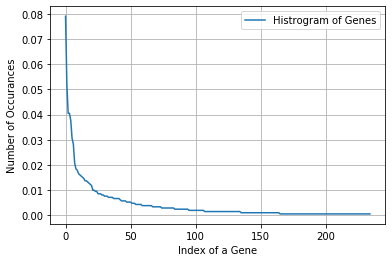

In [15]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

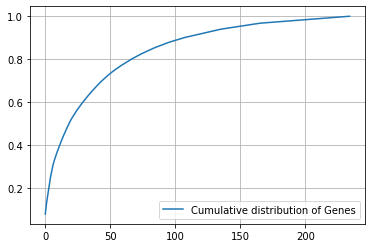

In [16]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

### Univariate Analysis on Variation Feature

In [17]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

print("*"*40+"\nThe top 10 variations that occured most\n")
print(unique_variations.head(10))

Number of Unique Variations : 1920
****************************************
The top 10 variations that occured most

Truncating_Mutations         58
Amplification                51
Deletion                     45
Fusions                      25
G12V                          4
Overexpression                3
Q61K                          2
R173C                         2
G12D                          2
Promoter_Hypermethylation     2
Name: Variation, dtype: int64


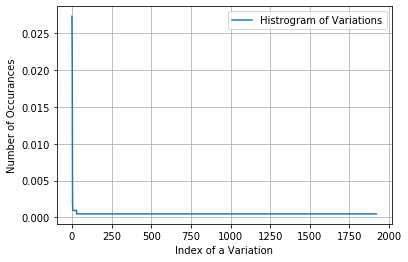

In [18]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02730697 0.05131827 0.07250471 ... 0.99905838 0.99952919 1.        ]


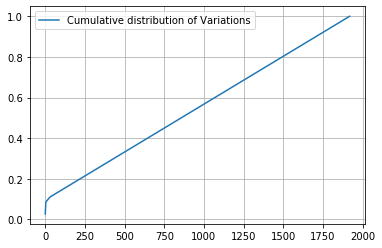

In [19]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

### Feature Engineering for 'gene' feature and 'variantion' feature

There are two ways to featurize these variables
1. One hot Encoding <br>
2. Response coding <br>

In [20]:
# code for response coding with Laplace smoothing.

def get_gv_fea_dict(alpha, feature):
    value_count = train_df[feature].value_counts()
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        # adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature,df):
    gv_dict = get_gv_fea_dict(alpha, feature)
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene/variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given dataframe it will check if it is there in the train data then it will add the feature to gv_fea
    # if not it will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))   # train gene feature

test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))     # test gene feature

cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))         # cross validation gene feature

In [22]:
print("train_gene_feature_responseCoding shape: ",train_gene_feature_responseCoding.shape)
print("test_gene_feature_responseCoding shape: ",test_gene_feature_responseCoding.shape)
print("cv_gene_feature_responseCoding shape: ",cv_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding shape:  (2124, 9)
test_gene_feature_responseCoding shape:  (665, 9)
cv_gene_feature_responseCoding shape:  (532, 9)


In [23]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [24]:
train_df['Gene'].head()

364      EPAS1
927     PDGFRA
2353     AURKA
2644     BRCA1
489       TP53
Name: Gene, dtype: object

In [25]:
print("Number of features after one hot encoding of 'Gene' :",len(gene_vectorizer.get_feature_names()))
gene_vectorizer.get_feature_names()

Number of features after one hot encoding of 'Gene' : 235


['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hras',
 'idh1',
 'idh2

In [26]:
print("train_gene_feature_onehotCoding shape: ",train_gene_feature_onehotCoding.shape)
print("test_gene_feature_onehotCoding shape: ",test_gene_feature_onehotCoding.shape)
print("cv_gene_feature_onehotCoding shape: ",cv_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding shape:  (2124, 235)
test_gene_feature_onehotCoding shape:  (665, 235)
cv_gene_feature_onehotCoding shape:  (532, 235)


In [27]:
# alpha is used for laplace smoothing
alpha = 1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))     # train gene feature

test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))       # test gene feature

cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))        # cross validation gene feature

In [28]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

### Feature Engineering on Text Feature

In [29]:
# create a dic for count of words in a text
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [30]:
import math
    
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [31]:
# building a CountVectorizer with words occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53778


In [32]:
# normalize the data
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


In [33]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


In [34]:
# response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [35]:
# convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [36]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [37]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.633 % of word of test data appeared in train data
98.029 % of word of Cross Validation appeared in train data


## Applying Machine Learning Models

In [38]:
# functionns for ML models to predict y and plot confusion matrix

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [39]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [40]:
# merging gene, variance and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


# merging response coding features
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [41]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55961)
(number of data points * number of features) in test data =  (665, 55961)
(number of data points * number of features) in cross validation data = (532, 55961)


In [42]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Naive Bayes

#### Hyper parameter tuning

for alpha = 1e-05
Log Loss : 1.3308057554641957
for alpha = 0.0001
Log Loss : 1.3300263984311003
for alpha = 0.001
Log Loss : 1.3230310017110363
for alpha = 0.1
Log Loss : 1.3159897881356832
for alpha = 1
Log Loss : 1.3298964895321972
for alpha = 10
Log Loss : 1.4195560235282285
for alpha = 100
Log Loss : 1.4243064663167042
for alpha = 1000
Log Loss : 1.3587559323469052


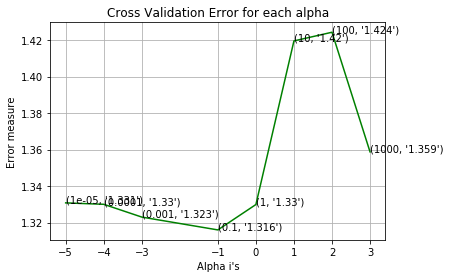

For values of best alpha =  0.1 The train log loss is: 0.8514224206640228
For values of best alpha =  0.1 The cross validation log loss is: 1.3159897881356832
For values of best alpha =  0.1 The test log loss is: 1.3274722521687765


In [44]:

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.3159897881356832
Number of missclassified point : 0.4116541353383459
			-------------------- Confusion matrix --------------------


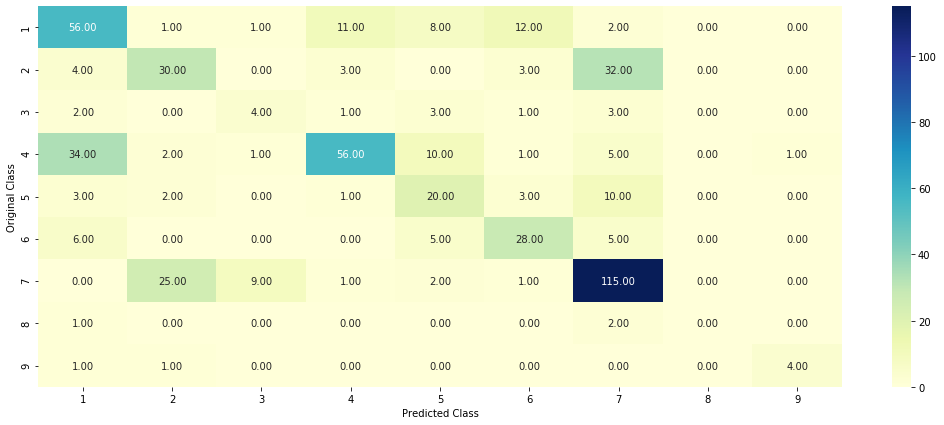

			-------------------- Precision matrix (Columm Sum=1) --------------------


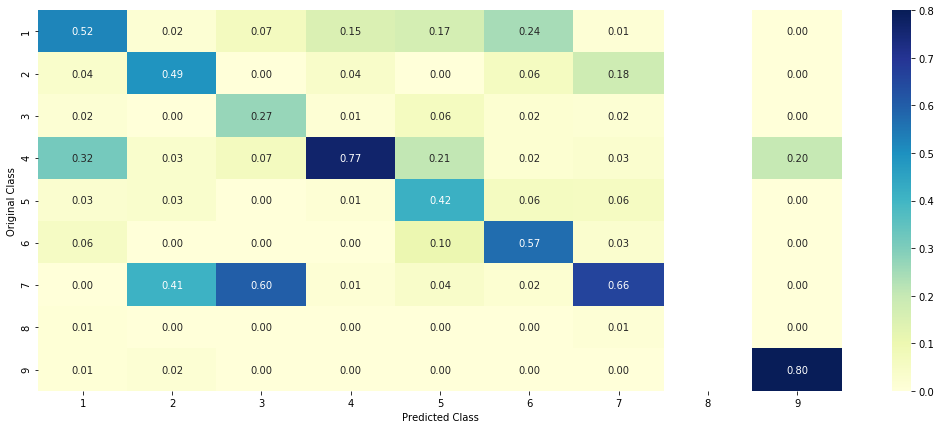

			-------------------- Recall matrix (Row sum=1) --------------------


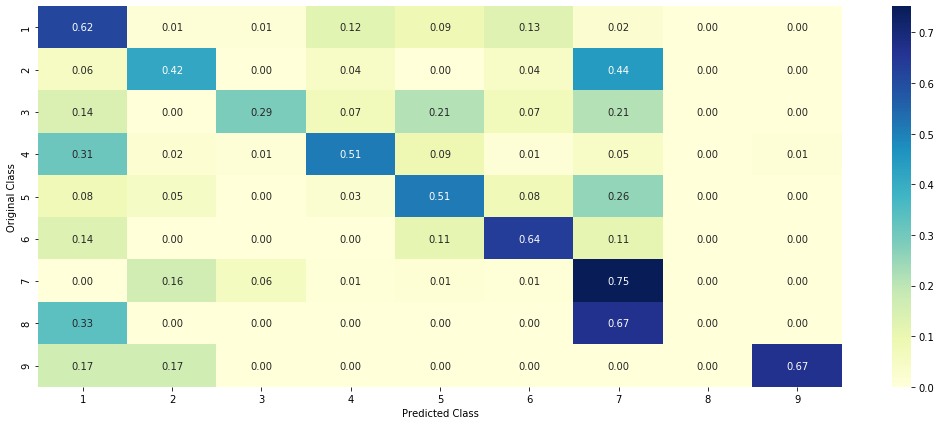

In [45]:
# Testing the model with best hyper paramters

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [46]:
import random
test_point_index_list = [random.randrange(1,100) for x in range(5)]
for i in test_point_index_list:
    predicted_cls = sig_clf.predict(test_x_onehotCoding[i])
    print("Predicted Class :"+str(predicted_cls[0])+"\tActual Class :", test_y[i])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[i]),4))
    print()

Predicted Class :6	Actual Class : 6
Predicted Class Probabilities: [[0.0718 0.0646 0.0134 0.0959 0.0342 0.5936 0.1182 0.0045 0.0039]]

Predicted Class :1	Actual Class : 1
Predicted Class Probabilities: [[0.574  0.0756 0.0157 0.1123 0.0401 0.0343 0.1382 0.0052 0.0046]]

Predicted Class :4	Actual Class : 1
Predicted Class Probabilities: [[0.0697 0.0626 0.013  0.6707 0.0331 0.0283 0.1144 0.0044 0.0038]]

Predicted Class :2	Actual Class : 7
Predicted Class Probabilities: [[0.0871 0.5506 0.0163 0.1161 0.0412 0.0353 0.1432 0.0055 0.0047]]

Predicted Class :7	Actual Class : 7
Predicted Class Probabilities: [[0.0767 0.069  0.0144 0.102  0.0365 0.0311 0.6613 0.0048 0.0042]]



## K Nearest Neighbour

### Hyper parameter tuning

for alpha = 5
Log Loss : 1.1726718425051388
for alpha = 11
Log Loss : 1.1215753595070248
for alpha = 15
Log Loss : 1.1335074284845508
for alpha = 21
Log Loss : 1.1331873078302095
for alpha = 31
Log Loss : 1.1442073036391438
for alpha = 41
Log Loss : 1.1300887179087862
for alpha = 51
Log Loss : 1.1251843536513761
for alpha = 99
Log Loss : 1.1316777286483344


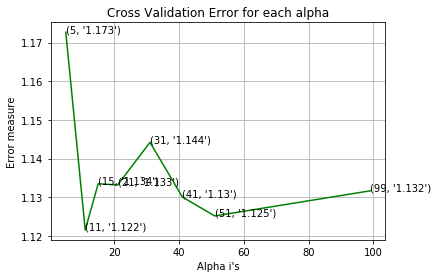

For values of best alpha =  11 The train log loss is: 0.5936632564930331
For values of best alpha =  11 The cross validation log loss is: 1.1215753595070248
For values of best alpha =  11 The test log loss is: 1.035219689496241


In [47]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.1215753595070248
Number of mis-classified points : 0.3890977443609023
			-------------------- Confusion matrix --------------------


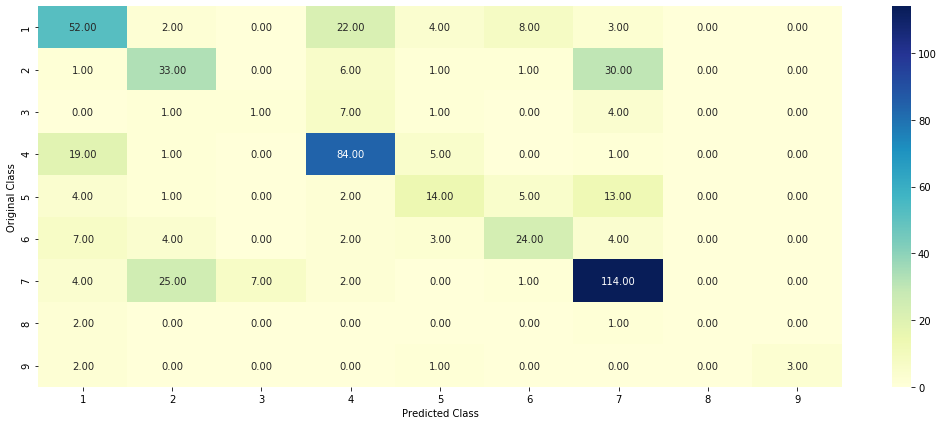

			-------------------- Precision matrix (Columm Sum=1) --------------------


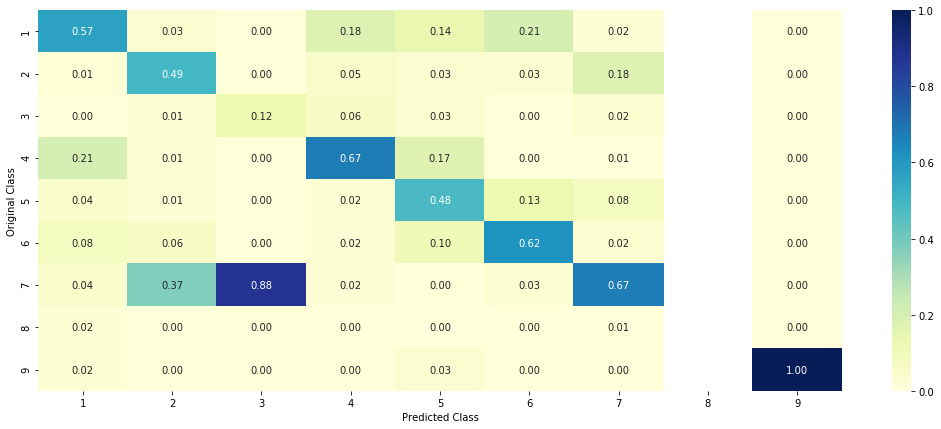

			-------------------- Recall matrix (Row sum=1) --------------------


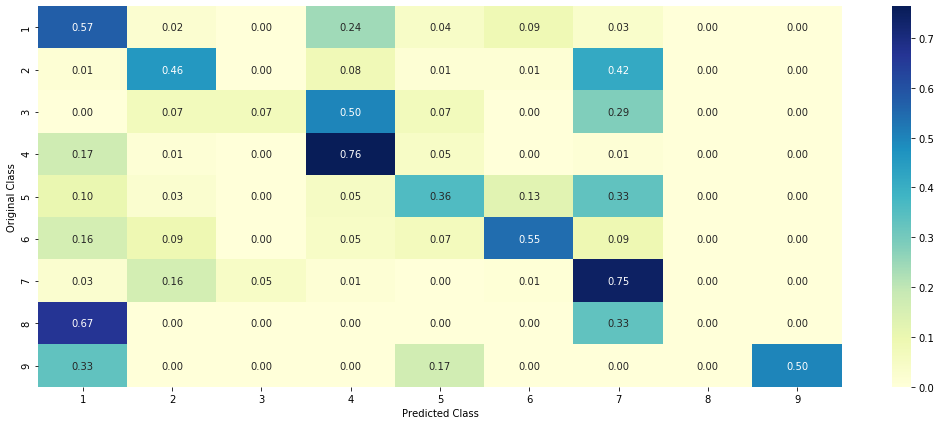

In [48]:
# Testing the model with best hyper paramters

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

## Logistic Regression

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 1.3368497330120834
for alpha = 1e-05
Log Loss : 1.3169802382502145
for alpha = 0.0001
Log Loss : 1.1557068943601065
for alpha = 0.001
Log Loss : 1.125642559407862
for alpha = 0.01
Log Loss : 1.22629043335573
for alpha = 0.1
Log Loss : 1.5227456049268973
for alpha = 1
Log Loss : 1.716257378771044
for alpha = 10
Log Loss : 1.7399744643706596
for alpha = 100
Log Loss : 1.7424551622276683


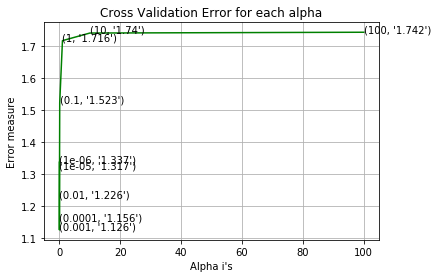

For values of best alpha =  0.001 The train log loss is: 0.5212371255689844
For values of best alpha =  0.001 The cross validation log loss is: 1.125642559407862
For values of best alpha =  0.001 The test log loss is: 1.1203480440878428


In [49]:

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.125642559407862
Number of mis-classified points : 0.35902255639097747
			-------------------- Confusion matrix --------------------


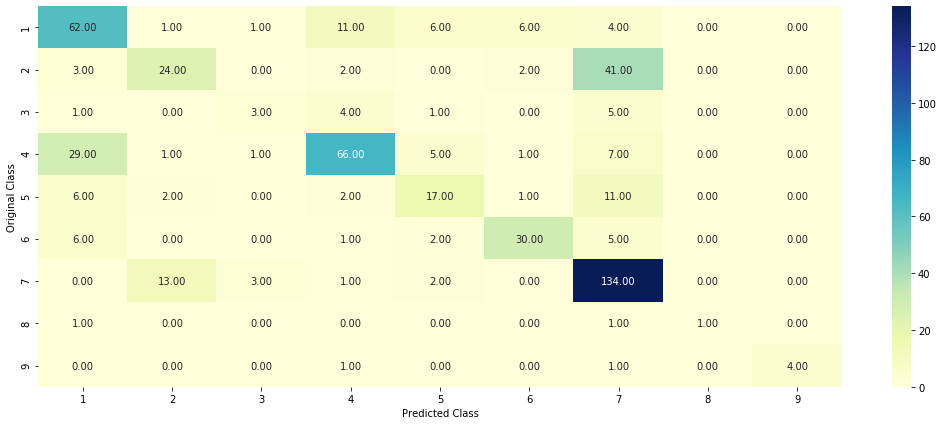

			-------------------- Precision matrix (Columm Sum=1) --------------------


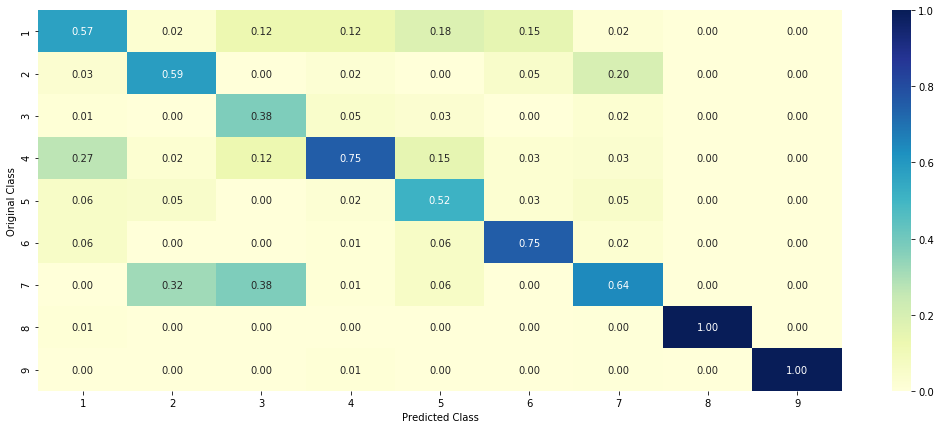

			-------------------- Recall matrix (Row sum=1) --------------------


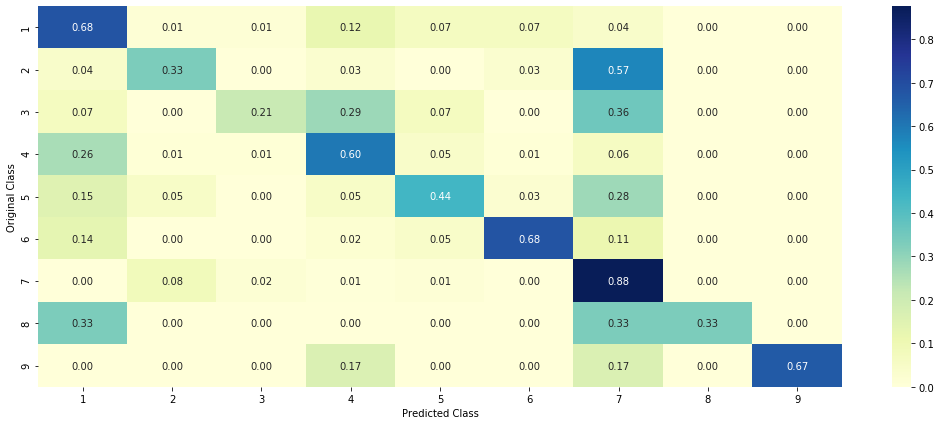

In [50]:
# Testing the model with best hyper paramters

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [51]:

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
import random
test_point_index_list = [random.randrange(1,100) for x in range(5)]
for i in test_point_index_list:
    predicted_cls = sig_clf.predict(test_x_onehotCoding[i])
    print("Predicted Class :"+str(predicted_cls[0])+"\tActual Class :", test_y[i])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[i]),4))
    print()

Predicted Class :1	Actual Class : 4
Predicted Class Probabilities: [[0.5333 0.0294 0.0042 0.0784 0.3174 0.0046 0.0242 0.0072 0.0013]]

Predicted Class :1	Actual Class : 1
Predicted Class Probabilities: [[9.658e-01 2.400e-03 1.400e-03 8.500e-03 3.800e-03 1.120e-02 2.700e-03
  3.800e-03 5.000e-04]]

Predicted Class :6	Actual Class : 4
Predicted Class Probabilities: [[6.450e-02 9.000e-04 1.600e-03 2.330e-02 9.500e-03 8.958e-01 2.000e-04
  4.000e-03 1.000e-04]]

Predicted Class :5	Actual Class : 5
Predicted Class Probabilities: [[0.0397 0.0157 0.0257 0.1499 0.6902 0.0618 0.0082 0.0067 0.0022]]

Predicted Class :7	Actual Class : 7
Predicted Class Probabilities: [[0.0174 0.0259 0.1228 0.0131 0.0456 0.013  0.7534 0.0055 0.0034]]



## Random Forest Classifier

### Hyper paramter tuning (With One hot Encoding)

In [52]:

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2585542969591716
for n_estimators = 100 and max depth =  10
Log Loss : 1.166593077953452
for n_estimators = 200 and max depth =  5
Log Loss : 1.2449478294202705
for n_estimators = 200 and max depth =  10
Log Loss : 1.1583529409409126
for n_estimators = 500 and max depth =  5
Log Loss : 1.242014986566226
for n_estimators = 500 and max depth =  10
Log Loss : 1.1545671874779009
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2380593917910612
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1529160559535112
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2362905351210314
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1511161291608918
For values of best estimator =  2000 The train log loss is: 0.6864967726514671
For values of best estimator =  2000 The cross validation log loss is: 1.1511161291608918
For values of best estimator =  2000 The test log loss is: 1.1693346336390842


### Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.151116129160892
Number of mis-classified points : 0.39849624060150374
			-------------------- Confusion matrix --------------------


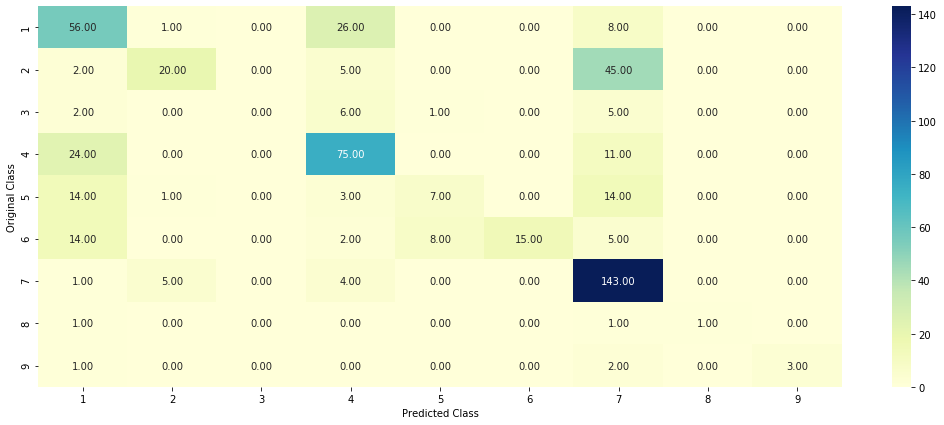

			-------------------- Precision matrix (Columm Sum=1) --------------------


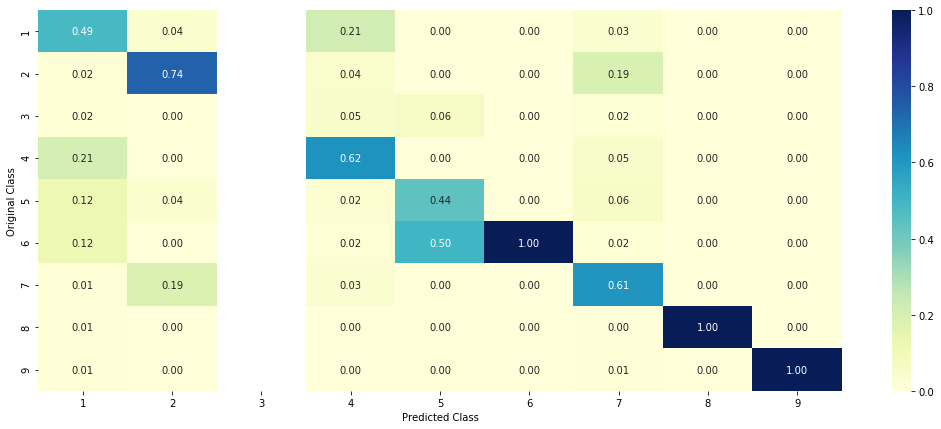

			-------------------- Recall matrix (Row sum=1) --------------------


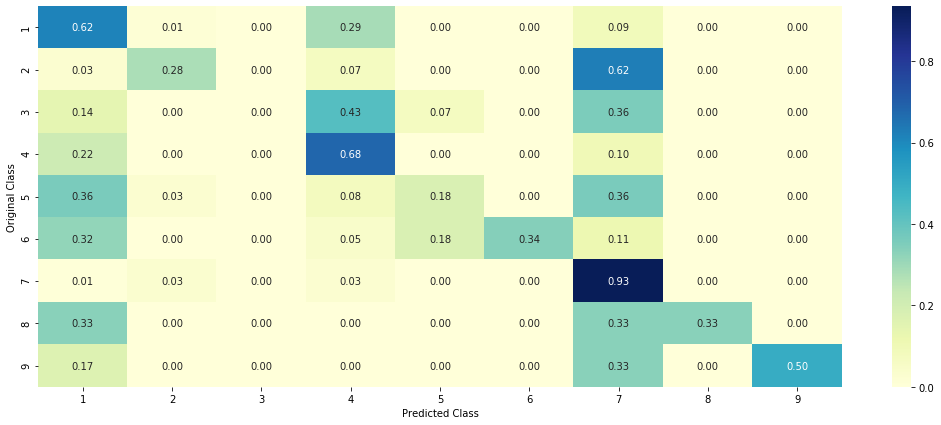

In [53]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### Hyper paramter tuning (With Response Coding)

In [54]:

alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1252685594387506
for n_estimators = 10 and max depth =  3
Log Loss : 1.8935553090076516
for n_estimators = 10 and max depth =  5
Log Loss : 1.632069057333119
for n_estimators = 10 and max depth =  10
Log Loss : 1.859733359148573
for n_estimators = 50 and max depth =  2
Log Loss : 1.6865299282521913
for n_estimators = 50 and max depth =  3
Log Loss : 1.4639908165902797
for n_estimators = 50 and max depth =  5
Log Loss : 1.5087013456114147
for n_estimators = 50 and max depth =  10
Log Loss : 1.6341088853076295
for n_estimators = 100 and max depth =  2
Log Loss : 1.5460837821018916
for n_estimators = 100 and max depth =  3
Log Loss : 1.4791461857861312
for n_estimators = 100 and max depth =  5
Log Loss : 1.3987635704300834
for n_estimators = 100 and max depth =  10
Log Loss : 1.7061747239468816
for n_estimators = 200 and max depth =  2
Log Loss : 1.5483693595033448
for n_estimators = 200 and max depth =  3
Log Loss : 1.4532259072934337

Log loss : 1.3987635704300834
Number of mis-classified points : 0.4924812030075188
			-------------------- Confusion matrix --------------------


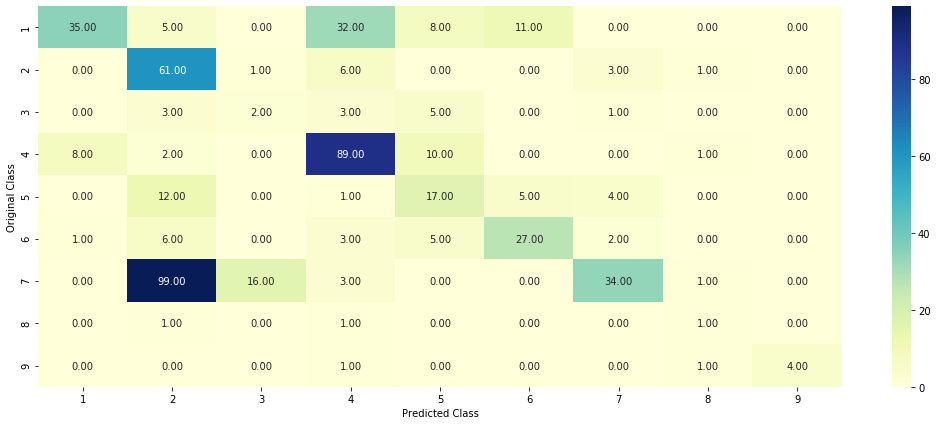

			-------------------- Precision matrix (Columm Sum=1) --------------------


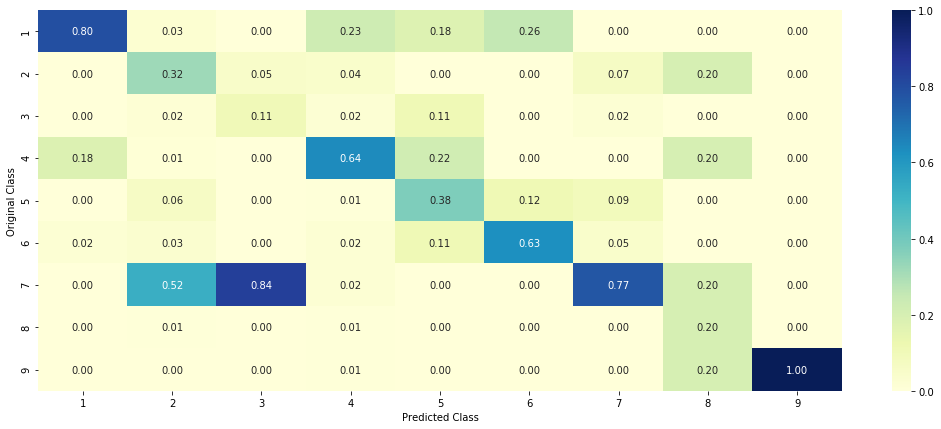

			-------------------- Recall matrix (Row sum=1) --------------------


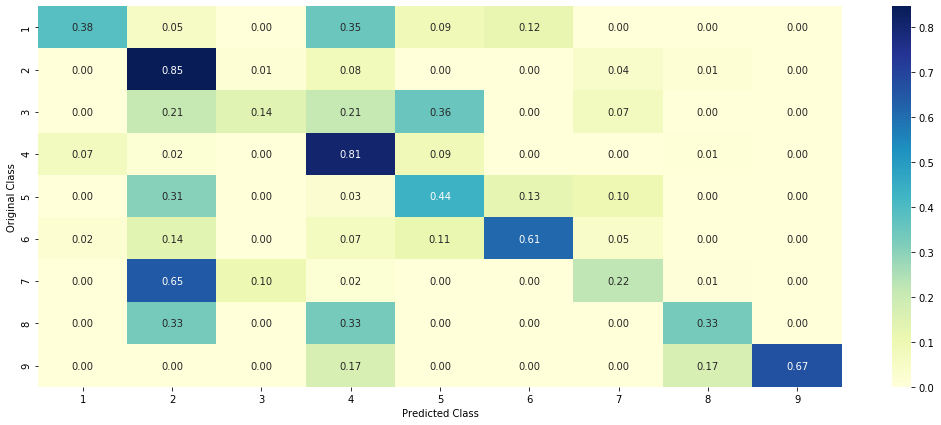

In [55]:
# Testing model with best hyper parameters (Response Coding)

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)